In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
import urllib.parse

from dotenv import load_dotenv

sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

In [2]:
load_dotenv(os.path.join(os.path.abspath(os.path.curdir), '.env'))

True

In [4]:
class StravaClient:
    def __init__(self, activity_id):
        token = os.getenv('TOKEN')
        self.__headers = {'Authorization': f'Bearer {token}'}
        self.__api_url = f'https://www.strava.com/api/v3/activities/{activity_id}/streams?'
    def get_stream(self, stream: str):
        response = requests.get(self.__api_url + f'keys={stream}&key_by_type=true', headers=self.__headers)
        return response.json()[stream]['data']

In [5]:
activity_id = 5298858628

In [6]:
client = StravaClient(activity_id)

In [7]:
cadence = client.get_stream('cadence')
dist = client.get_stream('distance')
hr = client.get_stream('heartrate')
pace = client.get_stream('velocity_smooth')
grade = client.get_stream('grade_smooth')

In [8]:
df = pd.DataFrame({'speed': pace, 'hr': hr, 'grade': grade, 'cadence': cadence, 'distance': dist})
df = df[df['cadence'] > 0]
df = df[df['speed'] > 1]
df['cadence'] = df['cadence'] * 2
# df.reset_index()
df = df.set_index('distance')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1174 entries, 7.4 to 4728.1
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   speed    1174 non-null   float64
 1   hr       1174 non-null   int64  
 2   grade    1174 non-null   float64
 3   cadence  1174 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 45.9 KB


(array([  4.,  26., 160., 660., 324.]),
 array([104. , 115.6, 127.2, 138.8, 150.4, 162. ]),
 <BarContainer object of 5 artists>)

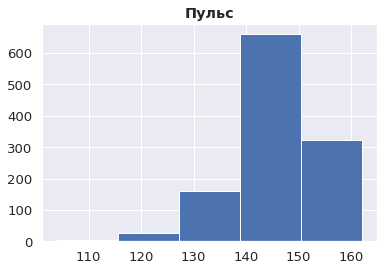

In [10]:
plt.title('Пульс', fontweight='bold')
plt.hist(df['hr'], bins=5)

array([[<AxesSubplot:title={'center':'speed'}>,
        <AxesSubplot:title={'center':'hr'}>],
       [<AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'cadence'}>]], dtype=object)

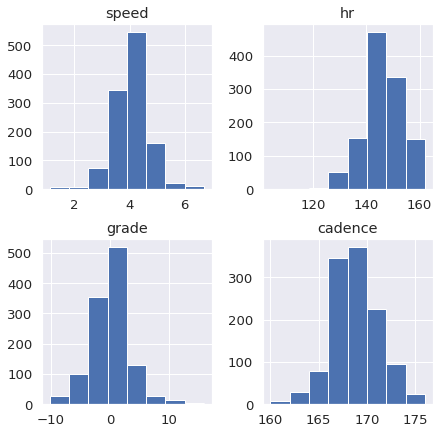

In [11]:
df.hist(figsize=(7,7), bins=8)

In [12]:
df['economy'] = (2**(df['grade'] / 100)) * 60 * df['speed'] / df['hr']

In [13]:
df['mva'] = df['economy'].rolling(window=60).mean()

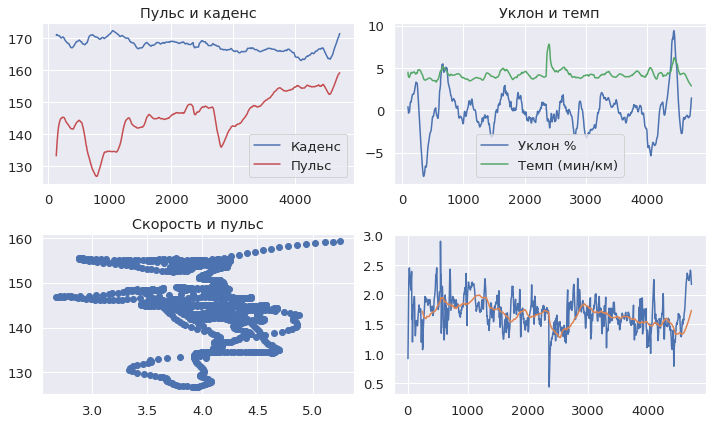

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0,0].set_title('Пульс и каденс')
ax[0,0].plot(df['cadence'].rolling(window=30).mean(), label='Каденс')
ax[0,0].plot(df['hr'].rolling(window=30).mean(), label='Пульс', color='r')
ax[0,0].legend()
ax[0,1].set_title('Уклон и темп')
ax[0,1].plot(df['grade'].rolling(window=20).mean(), label='Уклон %')
ax[0,1].plot((100 / df['speed'] / 6).rolling(window=20).mean(), label='Темп (мин/км)', color='g')
ax[0,1].legend()
ax[1,0].set_title('Скорость и пульс')
ax[1,0].scatter(df['speed'].rolling(window=30).mean(), df['hr'].rolling(window=30).mean())
ax[1,1].plot(df[['economy', 'mva']])
# fig.suptitle('Соотношение показателей', fontsize=16)
plt.tight_layout()

In [15]:
df.describe()

,speed,hr,grade,cadence,economy,mva
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1115.000000
mean,4.012095,145.749574,0.018825,167.793867,1.656627,1.646362
std,0.641841,7.753028,3.301013,2.553789,0.279789,0.162108
min,1.100000,104.000000,-10.200000,160.000000,0.440111,1.274094
25%,3.700000,142.000000,-1.900000,166.000000,1.483877,1.533573
50%,4.000000,146.000000,0.000000,168.000000,1.656576,1.638306
75%,4.300000,151.000000,1.500000,170.000000,1.816732,1.759916
max,6.700000,162.000000,15.900000,176.000000,2.897924,1.990448


In [16]:
df.corr()

,speed,hr,grade,cadence,economy,mva
speed,1.000000,-0.048902,-0.211739,0.214453,0.931461,0.270662
hr,-0.048902,1.000000,-0.025102,-0.407002,-0.379719,-0.621306
grade,-0.211739,-0.025102,1.000000,0.244927,-0.063297,0.028018
cadence,0.214453,-0.407002,0.244927,1.000000,0.364900,0.408084
economy,0.931461,-0.379719,-0.063297,0.364900,1.000000,0.455236
mva,0.270662,-0.621306,0.028018,0.408084,0.455236,1.000000


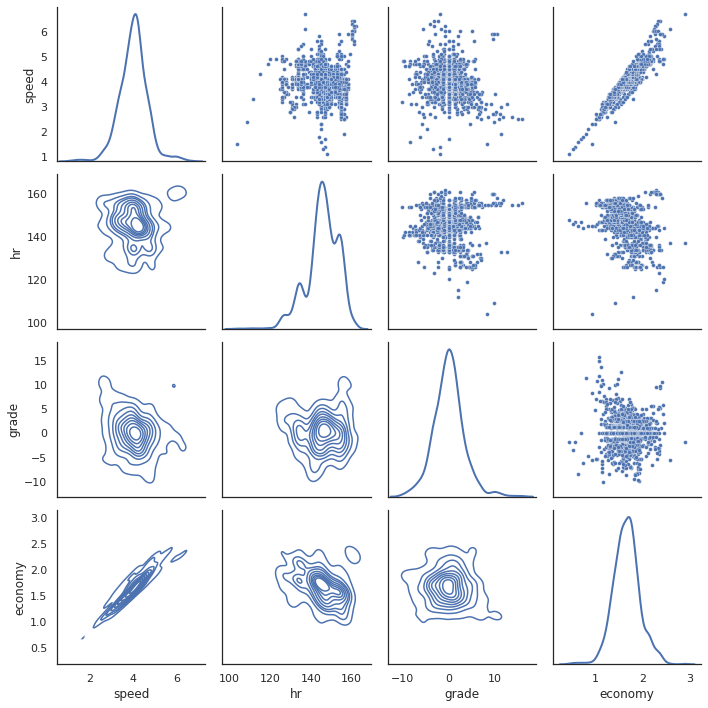

In [17]:
sns.set_theme(style="white")

g = sns.PairGrid(df[['speed', 'hr', 'grade', 'economy']], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

plt.tight_layout()
plt.savefig('activity.png')

In [18]:
from sklearn import linear_model
from sklearn import svm

In [19]:
classifiers = [
    svm.SVR(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()]

In [20]:
df = df.reset_index()

In [21]:
X = df[['hr','grade','cadence']]
y = df['speed'].values

In [22]:
for item in classifiers:
    print(item, end= ' -> ')
    clf = item
    clf.fit(X, y)
    t = 1000 / clf.predict([[168, 0, 172]])[0]
    t_min = int(t/60)
    t_sec = int((t/60 - t_min)*60)
    print(f'{t_min}:{t_sec:02d}')

SVR() -> 4:11
BayesianRidge() -> 3:44
LassoLars() -> 4:09
ARDRegression() -> 3:52
PassiveAggressiveRegressor() -> 3:58
TheilSenRegressor(max_subpopulation=10000) -> 4:17
LinearRegression() -> 3:43


In [23]:
X = df[['distance']]
Y = df[['economy']]
regressor = linear_model.LinearRegression()
regressor.fit(X,Y)

df1 = df[df['distance'] > 2500]
X1 = df1[['distance']]
Y1 = df1[['economy']]
regressor1 = linear_model.LinearRegression()
regressor1.fit(X1,Y1)

LinearRegression()

In [24]:
y_pred = regressor.predict(X)

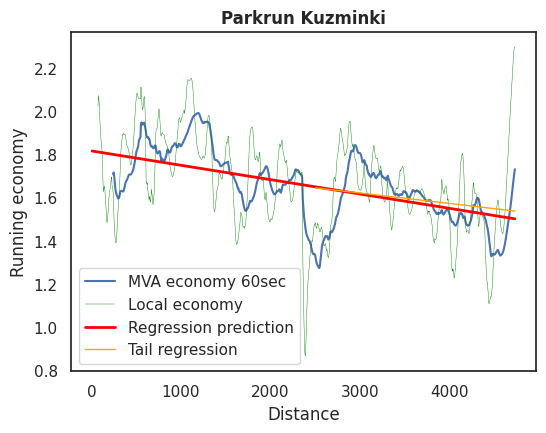

In [28]:
plt.figure(figsize=(6, 4.5), dpi=100)
# ax = fig.add_subplot()
plt.plot(X, df['mva'], label='MVA economy 60sec')
plt.plot(X, Y.rolling(window=15).mean(), color = 'green', lw=0.3, label='Local economy')
plt.plot(X, regressor.predict(X), color = 'red', lw=2, label='Regression prediction')
plt.plot(X1, regressor1.predict(X1), color = 'orange', lw=1, label='Tail regression')

plt.title('Parkrun Kuzminki', fontweight='bold')
plt.xlabel('Distance')
plt.ylabel('Running economy')
plt.legend()
plt.show()
